#### Adam Mischke
#### Open Lab 4
#### CSCI 4850-5850 - Neural Networks
#### Due: Apr. 26 @ 11:00pm
#### Generative Adversarial Networks

In [107]:
# imports
import keras
import keras.backend as K
from keras.utils.vis_utils import model_to_dot

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import SVG

In [108]:
# set the MNIST default image shape
rows = 28
cols = 28
channels = 1
image_shape = (rows, cols, channels)

# 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
num_classes = 10

# latent dimensions
latent_dim = 100

In [109]:
# Generator network
# used to be pit against the discriminator to become a better generator of fake MNIST images
# will be an inverse convolutional neural net by using up-sampling and normalization
# (instead of pooling)

# input layers
# one is used for adding noise to an image
# the other is used for the class label

# noise layer filled with (100,) images to generate noise
noise = keras.layers.Input(shape=(latent_dim,))

# label layer, which will be what label we generate (0-9)
label = keras.layers.Input(shape = (1, ), dtype = 'int32')

# embedding of the labels (10, 100) 
# inserting label -> label_embedding
label_embedding = keras.layers.Flatten()(keras.layers.Embedding(num_classes, 100)(label))

# multiply the noise by the label_embedding and create that as the input to the generator
# noise------------v
#                  o-----> generator_input
# label_embedding -^
generator_input = keras.layers.multiply([noise, label_embedding])


# hidden layers inbetween
# generator_input -> generator_hidden
# 6,272 units, number of input dimensions is 100
generator_hidden = keras.layers.Dense(units = 128 * 7 * 7, 
                                      activation = 'relu', 
                                      input_dim = latent_dim)(generator_input)

# reshaoe to have the input to switch the channels into the last dimension
# (7, 7, 128) shape
# rest all are generator -> hidden
generator_hidden = keras.layers.Reshape(target_shape = (7, 7, 128))(generator_hidden)

# normalize the batch with a momentum of 80%
generator_hidden = keras.layers.BatchNormalization(momentum = 0.8)(generator_hidden)

# upsampling of the first two dimensions
generator_hidden = keras.layers.UpSampling2D()(generator_hidden)

# convolutional layer with 128 filters, (3,3) kernels size, padding same
generator_hidden = keras.layers.Conv2D(filters = 128, 
                                       kernel_size = 3,
                                       padding = 'same',
                                       activation = 'relu')(generator_hidden)

# normalize the batch with a momentum of 80%
generator_hidden = keras.layers.BatchNormalization(momentum = 0.8)(generator_hidden)

# upsampling of the first two dimensions
generator_hidden = keras.layers.UpSampling2D()(generator_hidden)

# convolutional layer with 128 filters, (3,3) kernels size, padding same
generator_hidden = keras.layers.Conv2D(filters = 64, 
                                       kernel_size = 3,
                                       padding = 'same',
                                       activation = 'relu')(generator_hidden)

# normalize the batch with a momentum of 80%
generator_hidden = keras.layers.BatchNormalization(momentum = 0.8)(generator_hidden)

# convolutional layer with 1 filters, (3,3) kernels size, padding same
generated_image  = keras.layers.Conv2D(filters = channels, 
                                       kernel_size = 3,
                                       padding = 'same',
                                       activation = 'tanh')(generator_hidden)

# finalizing the model
#              >------------>noise>-----------v
#  generator-->o                              o-----> generated_image
#              >------------>label>-----------^
generator = keras.Model(inputs = [noise, label], outputs = generated_image)

# loss function of binary crossentropy
# Adam optimizer with learning rate smaller than default: 0.001
# and beta_1 (momentum) lower than default: 0.9
generator.compile(loss = ['binary_crossentropy'],
                  optimizer = keras.optimizers.Adam(lr = 0.0002, 
                                                    beta_1 = 0.5))

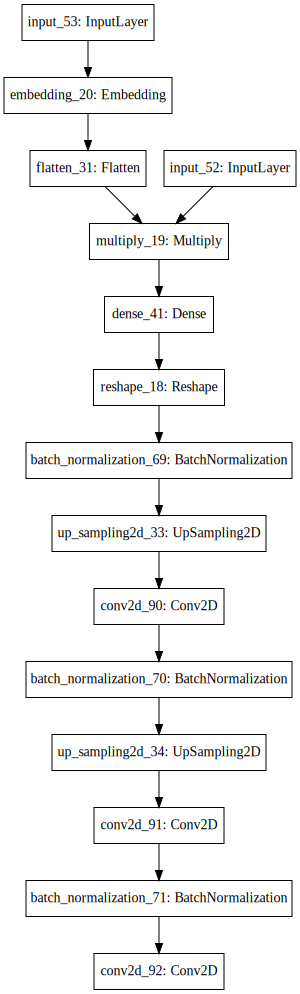

In [110]:
# model structure view
SVG(model_to_dot(generator).create(prog = 'dot',
                                   format = 'svg'))

In [111]:
# Discriminator

# Input for discriminator.model is an image
# where the image shape is (28, 28, 1)
discriminator_image = keras.layers.Input(shape = image_shape)

# hidden layers
# discriminator_image -> discriminator_hidden
# first with a 16 filter, 3 kernel size, 2 strides, and an input shape of (28, 28, 1)
discriminator_hidden = keras.layers.Conv2D(filters = 16,
                                           kernel_size = 3,
                                           strides = 2,
                                           input_shape = image_shape,
                                           padding = 'same')(discriminator_image)

# rest discriminator_hidden -> discriminator_hidden
# leaky relu with alpha 0.2
discriminator_hidden = keras.layers.LeakyReLU(alpha = 0.2)(discriminator_hidden)

# dropout 1/4
discriminator_hidden = keras.layers.Dropout(rate = 0.25)(discriminator_hidden)

# conv with smaller filters
discriminator_hidden = keras.layers.Conv2D(filters = 32,
                                           kernel_size = 3,
                                           strides = 2,
                                           padding = 'same')(discriminator_hidden)

# add padding ((0, 1), (0, 1))
discriminator_hidden = keras.layers.ZeroPadding2D(padding = ((0,1), (0,1)))(discriminator_hidden)

# leaky relu with alpha 0.2
discriminator_hidden = keras.layers.LeakyReLU(alpha = 0.2)(discriminator_hidden)

# dropout 1/4
discriminator_hidden = keras.layers.Dropout(rate = 0.25)(discriminator_hidden)

# normalize the batch with a momentum of 80%
discriminator_hidden = keras.layers.BatchNormalization(momentum = 0.8)(discriminator_hidden)

# conv with bigger filters
discriminator_hidden = keras.layers.Conv2D(filters = 64,
                                           kernel_size = 3,
                                           strides = 2,
                                           padding = 'same')(discriminator_hidden)
# leaky relu with alpha 0.2
discriminator_hidden = keras.layers.LeakyReLU(alpha = 0.2)(discriminator_hidden)

# dropout 1/4
discriminator_hidden = keras.layers.Dropout(rate = 0.25)(discriminator_hidden)

# normalize the batch with a momentum of 80%
discriminator_hidden = keras.layers.BatchNormalization(momentum = 0.8)(discriminator_hidden)

# conv with even BIGGER filters
discriminator_hidden = keras.layers.Conv2D(filters = 128,
                                           kernel_size = 3,
                                           strides = 1,
                                           padding = 'same')(discriminator_hidden)
# leaky relu with alpha 0.2
discriminator_hidden = keras.layers.LeakyReLU(alpha = 0.2)(discriminator_hidden)

# dropout 1/4
discriminator_hidden = keras.layers.Dropout(rate = 0.25)(discriminator_hidden)

# flatten the dimension
discriminator_hidden = keras.layers.Flatten()(discriminator_hidden)

# outputs have a probability of being real
valid = keras.layers.Dense(units = 1,
                           activation = 'sigmoid')(discriminator_hidden)

# and a probability of what class of fakes
target_label = keras.layers.Dense(units = num_classes + 1,
                                  activation = 'softmax')(discriminator_hidden)


# finalizing the model
#              >------------>noise>-----------v
#  generator-->o                              o-----> generated_image
#              >------------>label>-----------^
discriminator = keras.Model(inputs = discriminator_image,
                            outputs = [valid, target_label])

# loss function of binary crossentropy
# Adam optimizer with learning rate smaller than default: 0.001
# and beta_1 (momentum) lower than default: 0.9
discriminator.compile(loss = ['binary_crossentropy', 'sparse_categorical_crossentropy'],
                      optimizer = keras.optimizers.Adam(lr = 0.0002, 
                                                        beta_1 = 0.5),
                      metrics = ['accuracy'])

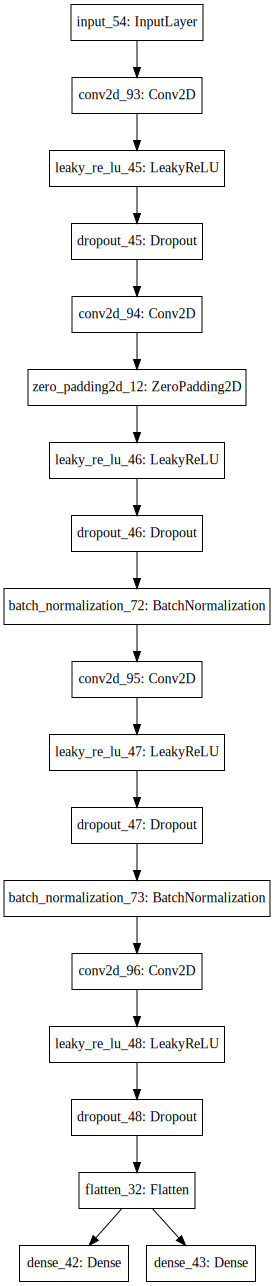

In [112]:
# model structure view
SVG(model_to_dot(discriminator).create(prog = 'dot',
                                       format = 'svg'))

In [113]:
# combined model of generator and discriminator

discriminator.trainable = False

valid, target_label = discriminator(generated_image)

combined = keras.Model([noise, label], [valid, target_label])
combined.compile(loss = ['binary_crossentropy', 'sparse_categorical_crossentropy'],
                 optimizer = keras.optimizers.Adam(lr = 0.0002, 
                                                   beta_1 = 0.5))

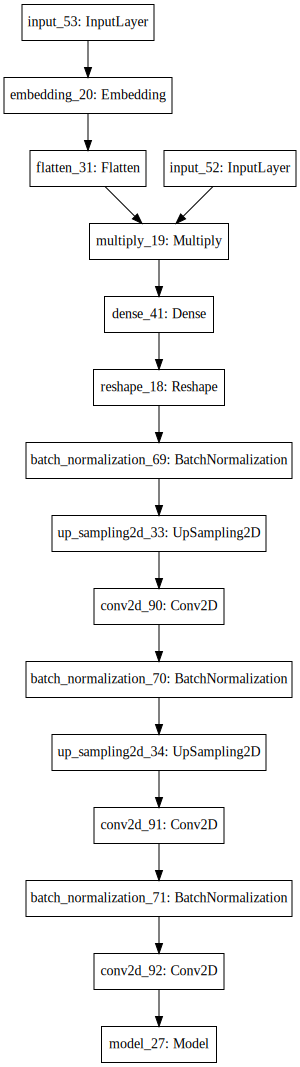

In [114]:
# model structure view
SVG(model_to_dot(combined).create(prog = 'dot',
                                  format = 'svg'))

In [115]:
# load the MNIST image data
(X_train, Y_train), (_, _) = keras.datasets.mnist.load_data()

# normalize -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis = 3)

# reshape Y to -1, 1
Y_train = Y_train.reshape(-1, 1)

print(X_train.shape)
print(Y_train.shape)

(60000, 28, 28, 1)
(60000, 1)


In [116]:
# Training parameters
history = [[], [], [], []]

batch_size = 32
half_batch_size = int(batch_size / 2)

epochs = 20000

In [117]:
# training time!

for epoch in range(epochs):
    
    # discriminator training
    # use half of the MNIST data set
    idx = np.random.randint(0, X_train.shape[0], half_batch_size)
    real_images = X_train[idx]
    
    # generator some gaussian noise of random 100-element vectors
    # inputs -> generator -> "fakes"
    # choose a true or fake image
    noise = np.random.normal(0, 1, (half_batch_size, 100))
    
    # random vectors associated with a class
    # ask the generator to make these numbers
    # choose a number from 0-10 class label
    sampled_labels = np.random.randint(0, 10, half_batch_size).reshape(-1, 1)
    
    # use the generator to make the images
    generated_images = generator.predict([noise, sampled_labels])
    
    # generate the real-fake target distinctions
    # reals are 1.0 (100% real)
    # fakes are 0.0 (0.0% real)
    valid = np.ones([half_batch_size, 1])
    fake = np.ones([half_batch_size, 1])
    
    # use the labeled classes for the real images
    image_labels = Y_train[idx]
    
    # assign fake images to the extra class, fake class
    # one-hot encoding for all fake images
    # (they are not 0-9)
    # we don't use the generator labels
    fake_labels = 10 * np.ones(half_batch_size).reshape(-1, 1)
    
    # train the discriminator, two groups
    d_loss_real = discriminator.train_on_batch(real_images, [valid, image_labels])
    d_loss_fake = discriminator.train_on_batch(generated_images, [fake, fake_labels])
    # calculate the average for an overall loss/accuracy for the discriminator
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # generator training
    
    # make some noise!
    # random number from 0-1
    noise = np.random.normal(0, 1, (batch_size, 100))
    
    # using the combined model to brackprop the loss to the generator
    # therefore, make new targets
    
    # call these real images, but try to fake out the discriminator
    # set the target as if the generated images were real
    valid = np.ones([batch_size, 1])
    
    # give them some labels so the generator can learn which digit
    # it is trying to fake, pick a random number from 0-9
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
    
    # train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])
    
    # add all of these results manually to history
    history[0] += [d_loss[0]]
    history[1] += [d_loss[3]]
    history[2] += [d_loss[4]]
    history[3] += [g_loss[0]]
    
    # print progress
    print('\r%d[Discriminator Loss:%f]' 
                '[Real/Fake-Acc.:%.2f%%]'
                '[Classification-Acc:%.2f%%]'
                '[Generator Loss:%f]'%(epoch,d_loss[0],
                                      100*d_loss[3],
                                      100*d_loss[4],
                                      g_loss[0]),end='')


/home/csci4850/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


13198[Discriminator Loss:0.811121][Real/Fake-Acc.:100.00%][Classification-Acc:53.12%][Generator Loss:0.909516]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19999[Discriminator Loss:0.806128][Real/Fake-Acc.:100.00%][Classification-Acc:50.00%][Generator Loss:0.829738]

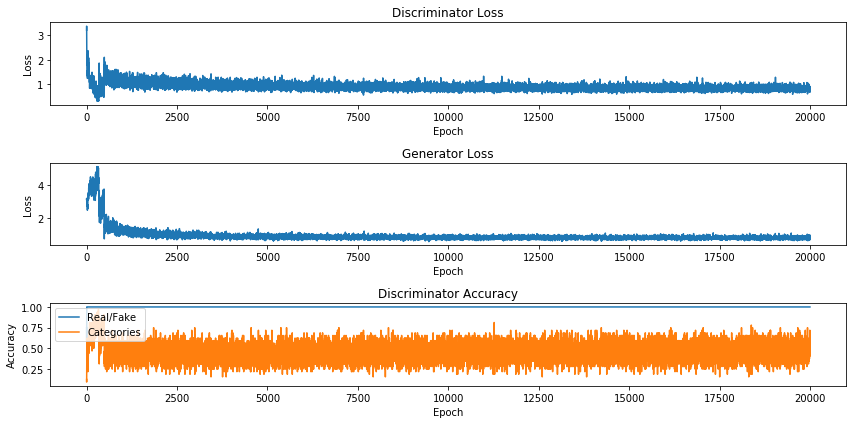

In [118]:
# plotting
plt.figure(1,figsize=(12,6))

plt.subplot(311)
plt.plot(history[0])
plt.title('Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(312)
plt.plot(history[3])
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(313)
plt.plot(history[1])
plt.plot(history[2])
plt.title('Discriminator Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Real/Fake','Categories'],loc='upper left')
plt.tight_layout()
plt.show()

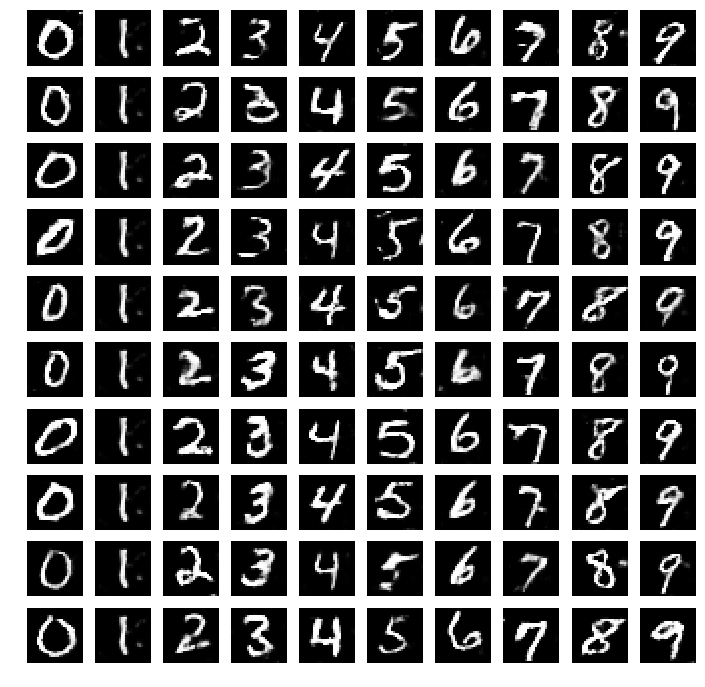

In [119]:
# testing
rows, columns = 10, 10

# pick some random labels to sample from
noise = np.random.normal(0, 1, (rows * columns, 100))
sampled_labels = np.array([num for _ in range(rows) for num in range(columns)])

# make some fake images
generated_images = generator.predict([noise, sampled_labels])
# rescale them: 0 - 1
generated_images = 0.5 * generated_images + 1

# plot images
fig, axs = plt.subplots(rows, columns)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0

for i in range(rows):
    for j in range(columns):
        axs[i, j].imshow(generated_images[count, :, :, 0], cmap = 'gray')
        axs[i, j].axis('off')
        count += 1
plt.show()

#### WOW! Look at those numbers! Those are fake, but they don't look like it!!